## Group Information
## Week 6 Track 2
### Tream 4
### members:
Weizhao Wang

Fulin Jiang

Kunwei Song


# Week 4 Notebook

## Track 2 TODO 1:  Retrieve predicted segmentation mask and estimated joints from pretrained network
 
For the first part of our animation pipeline, we will use the pretrained objection detection model and segmentation method from author's implementation to obtain a segmentation mask for our own drawing. Your first task is:
1. Go to the Github repository https://github.com/facebookresearch/AnimatedDrawings/tree/main, follow the instructions in "animating-your-own-drawing" https://github.com/facebookresearch/AnimatedDrawings/tree/main#animating-your-own-drawing) to obtain a segmentation mask "mask.png", a texture map "texture.png", and locations of detected joint skeleton in "char_cfg.yaml" using the example drawing "garlic.png"
2. Write code to load the segmentation mask and the original image, compose and visualize a masked image using Matplotlib
3. Load detected joint locations, use Matplotlib to visualize the locations and labels of the joints. Visualize the tree hierarchy of the skeleton using lines (See desired output in session slide)
4. Make your own drawing, and repeat step 1-3 

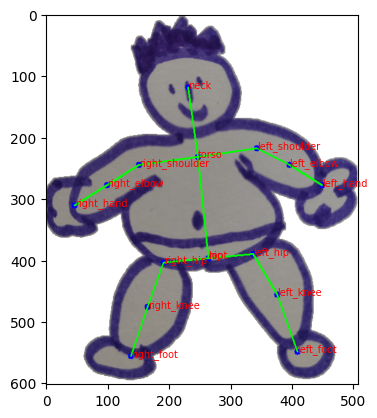

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('char1/mask.png')
background = np.bitwise_not(img)
ori_img = cv2.imread('char1/texture.png')
img = np.bitwise_and(img, ori_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.add(img, background)
plt.imshow(img)

import yaml
with open('char1/char_cfg.yaml') as f:
    data = yaml.load(f, Loader=yaml.FullLoader)

for joint in data['skeleton']:
    cv2.circle(img, tuple(joint['loc']), 5, (0, 0, 255), -1)
    plt.text(joint['loc'][0],joint['loc'][1],joint['name'],color='red',fontsize=7)
plt.imshow(img)

for node in data['skeleton']:
    if node['parent'] is not None:
        for name in data['skeleton']:
            if name['name'] == node['parent']:
                cv2.line(img, tuple(node['loc']), tuple(name['loc']), (0, 255, 0), 2)
plt.imshow(img)

## Track 2 TODO 2:  2D Mesh Generation using delaunay triangulation
For the second part of our animation pipeline, we need to generate a 2D mesh from our masked image that we can use for rigging during the animation phase. Your task is
1. Generate random points using Poisson Disk Sampling (https://medium.com/@hemalatha.psna/implementation-of-poisson-disc-sampling-in-javascript-17665e406ce1) as points in our mesh
2. Use Delaunay triangulation to generate a 2D triangle mesh from sampled points
3. Visualize the generated 2D mesh using Matplotlib


Poisson Disk Sampling... Total number of points: 165618
It takes around 2 minutes and 15 seconds


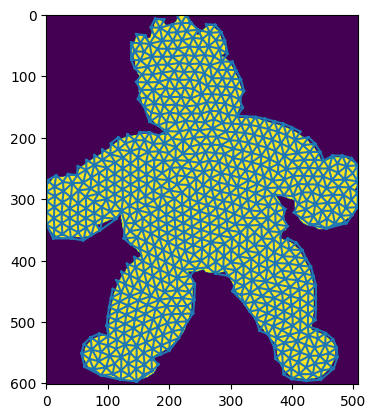

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import numpy as np 
import matplotlib.tri as tri
random.seed(1)
img = cv2.imread('char1/mask.png', cv2.IMREAD_GRAYSCALE)
_, img = cv2.threshold(img, 127, 1, cv2.THRESH_BINARY)
kernel = np.ones((5, 5), np.uint8) 
img_dilation = cv2.dilate(img, kernel, iterations=2)
x, y = np.where(img_dilation == 1)
points = list(np.stack((x, y), axis=-1))
background = np.bitwise_not(img)

def count_distance(p0,p1):
    return np.linalg.norm(p0-p1)

def poissonDiskSampling(points,r):
    i = 0
    while i < len(points):
        j = i+1
        while j<len(points):
            if count_distance(points[i],points[j]) <= r:
                points.pop(j)
                j -= 1
            j += 1
        i += 1
    return points
print("Poisson Disk Sampling... Total number of points:", len(points))
print("It takes around 2 minutes and 15 seconds")
points = poissonDiskSampling(points,15)

def generate_triangles(points):
    x = np.array([point[1] for point in points])
    y = np.array([point[0] for point in points])
    Triangle = tri.Triangulation(x,y)
    xmean = x[Triangle.triangles].mean(axis = 1)
    ymean = y[Triangle.triangles].mean(axis = 1)

    i = 0
    while i < len(Triangle.triangles):
        if background[int(ymean[i]),int(xmean[i])] == 255:
            Triangle.triangles = np.delete(Triangle.triangles,i,axis = 0)
            ymean = np.delete(ymean,i)
            xmean = np.delete(xmean,i)
            i -= 1
            continue
        i += 1

    return Triangle

Triangle = generate_triangles(points)

plt.imshow(img)
plt.triplot(Triangle)
plt.show()

# Week 5 Notebook

## Track 2 TODO 1: Render your generated 2D mesh with texture
We are now ready to render our 2D mesh with a rendering engine (PyVista) using the generated 2D mesh. To do so,
1. Output your generated 2D mesh into an obj format (https://en.wikipedia.org/wiki/Wavefront_.obj_file). Since our mesh is 2D, you can set the coordinate for z-axis to be 0. Make sure to include the computed texture coordinate for each triangle vertex, where the texture is the original drawing image. You can compute the texture coordinate for each vertex with pixel location $(p_x, p_y)$ using $ (p_x/width, p_y/height) $
2. Load your obj file using the trimesh library's mesh = trimesh.load(file_path) function. You can then initialize a plotter object in PyVista using plotter = pyvista.Plotter(...). Load your drawing as a texture file, then use plotter.add_mesh(mesh, texture=...) (https://docs.pyvista.org/version/stable/api/plotting/_autosummary/pyvista.Plotter.add_mesh.html) to create a textured mesh.
3. Visualize the textured mesh by calling plotter.show()

/Users/jiangfulin/miniconda3/envs/animated_drawings/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


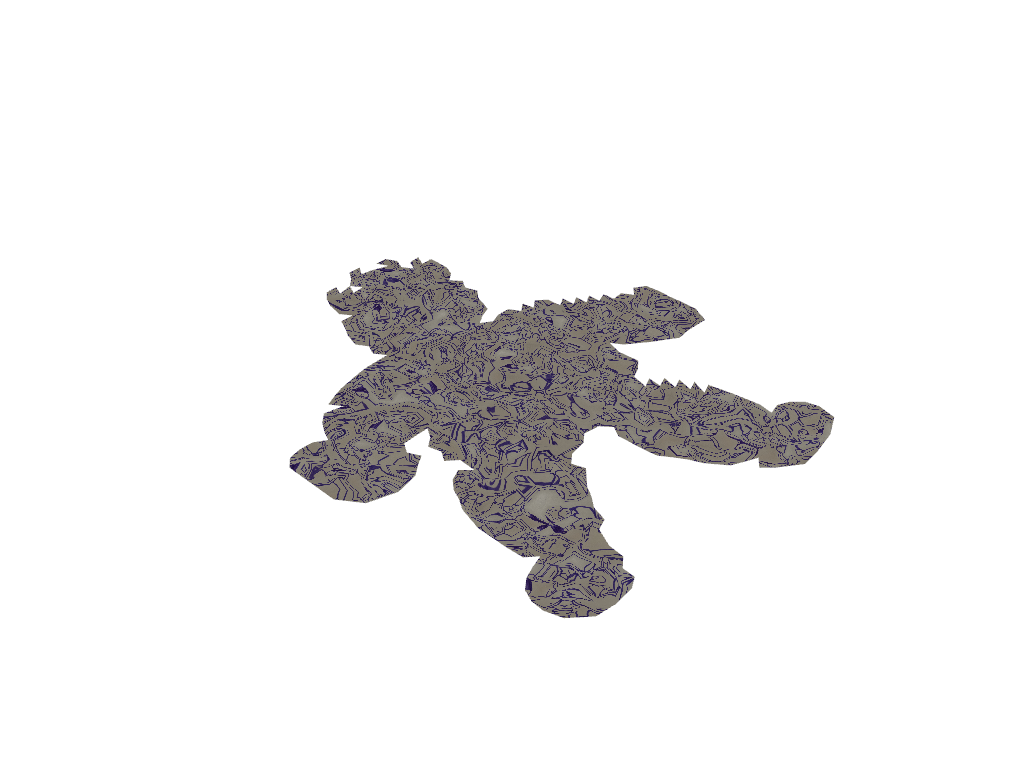

In [32]:
import pyvista as pv
import trimesh
from PIL import Image
# output triangle as obj file
img = cv2.imread('char1/mask.png')
height, width = img.shape[:2]
# with open('char1/char1.obj','w') as f:
#     for tria in Triangle.triangles:
#         f.write(f"f ({x[tria][0]/width},{y[tria][0]/height}) ({x[tria][1]/width},{y[tria][1]/height}) ({x[tria][2]/width},{y[tria][2]/height})\n")

def visualize_mesh(Triangle):
    with open('char1/char1.obj','w') as f:
        for i in range(len(Triangle.x)):
            f.write(f"v {Triangle.x[i]} {Triangle.y[i]} {0}\n")
        for i in range(len(Triangle.triangles)):
            f.write(f"f {Triangle.triangles[i][0]+1}//{i+1} {Triangle.triangles[i][1]+1}//{i+1} {Triangle.triangles[i][2]+1}//{i+1}\n")

    m = trimesh.load('char1/char1.obj')
    texture_im = Image.open('char1/texture.png')
    texture = trimesh.visual.TextureVisuals(image=texture_im)
    uv = np.random.rand(m.vertices.shape[0], 2)
    material = trimesh.visual.texture.SimpleMaterial(image=texture_im)
    color_visuals = trimesh.visual.TextureVisuals(uv=uv, image=texture_im, material=material)   
    mesh=trimesh.Trimesh(vertices=m.vertices, faces=m.faces, visual=color_visuals, validate=True, process=False)
    mesh.visual = color_visuals
    plotter = pv.Plotter()
    plotter.add_mesh(mesh, texture=np.array(texture_im))
    plotter.show()

visualize_mesh(Triangle=Triangle)

## Track 2 TODO 2: Use As-Rigid-As-Possible to deform your mesh.
Our animation pipeline will use the As-Rigid-As-Possible algorithm to animate our textured 2D mesh. You can reference Animated Drawing for an example implementation of the ARAP algorithm (https://github.com/facebookresearch/AnimatedDrawings/blob/main/animated_drawings/model/arap.py). 
1. Add ARAP to your pipeline, which allows you to supply as inputs the vertices to deform (vertices on your 2D textured mesh), handle locations (the detected joints for the drawing), target handle locations (target location for the joints) and output the positions for the deformed mesh.
2. Modify the character joint location you loaded to create a new target pose, then use ARAP to compute the deformed mesh.
3. Visualize the deformed mesh using the visualization pipeline you created in TODO 1

In [6]:
joints = []
for joint in data['skeleton']:
    joints.append(joint['loc'][::-1])
    m = np.array([joint['loc'][0],joint['loc'][1],0])
np.array(joints)

array([[397, 264],
       [397, 264],
       [232, 247],
       [119, 231],
       [245, 151],
       [278,  99],
       [311,  46],
       [218, 343],
       [245, 396],
       [278, 449],
       [404, 191],
       [476, 165],
       [556, 138],
       [390, 337],
       [456, 376],
       [549, 409]])

/Users/gabe/miniconda3/envs/animated_drawings/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


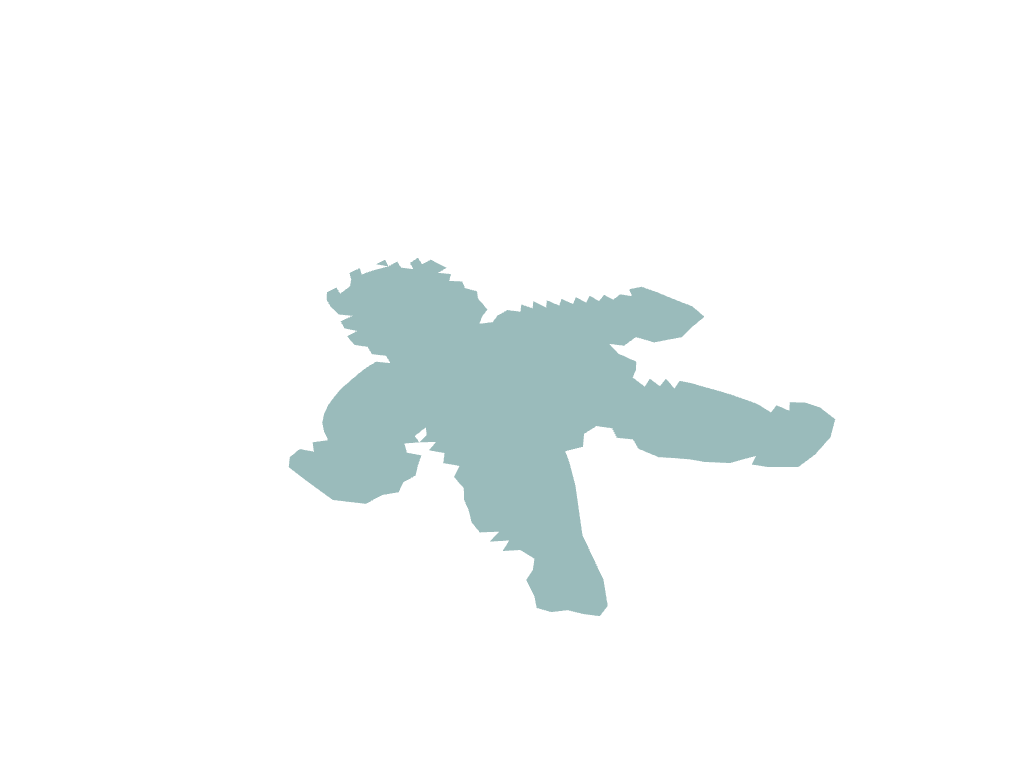

In [7]:
from arap import ARAP, plot_mesh
deformed_mesh = ARAP(np.array(joints), Triangle.triangles, np.array(points))
new_joints = joints.copy()
new_joints[13] = [390, 357]
new_joints[14] = [456, 406]
new_joints[15] = [549, 439]
new_points = deformed_mesh.solve(np.array(new_joints))
new_triangles = generate_triangles(new_points)
visualize_mesh(new_triangles)

# Week 6 Notebook

We are now ready to put together a 2D animation for our drawing. An example drawing config file is specified under examples/scene_config.yaml, which uses char2 in examples/characters/char2. Run the cell below to load and process the specified character and corresponding motion file.

In [8]:
import sys
import os
# Path to your scene config file
path = 'examples/scene_config.yaml'

# Assuming your notebook is in the parent directory of AnimatedDrawing
notebook_dir = os.getcwd()
animated_drawing_dir = os.path.join(notebook_dir, 'AnimatedDrawing')

# Add this directory to sys.path
if animated_drawing_dir not in sys.path:
    sys.path.insert(0, animated_drawing_dir)
 
from collections import defaultdict
from pathlib import Path
from typing import Union, List, Tuple, Dict, TypedDict, Optional
import yaml
from config import ViewConfig, SceneConfig, ControllerConfig
from animated_drawing import AnimatedDrawing
with open(str(path), 'r') as f:
        user_cfg = defaultdict(dict, yaml.load(f, Loader=yaml.FullLoader) or {})  # pyright: ignore[reportUnknownMemberType]
base_path = 'examples/mvc_base_cfg.yaml'
with open(str(path), 'r') as f:        
        base_cfg = defaultdict(dict, yaml.load(f, Loader=yaml.FullLoader) or {})  # pyright: ignore[reportUnknownMemberType]

# overlay user specified mvc options onto base mvc, use to generate subconfig classes
sceneConfig = SceneConfig({**base_cfg['scene'], **user_cfg['scene']})

char0 = sceneConfig.animated_characters[0]
characterMotion = AnimatedDrawing(*char0)

# Understanding the rigging and retargetting file
You will use the characterMotion object to get the updated joint position for different frames during the animation. Specifically
- Use characterMotion.set_time(t) to set the current time
- characterMotion.getUpdatedJointPositions() will return a 2D numpy matrix storing the updated joint positions at time t, followed by the position of the root_joint. The joint_positions are calculated such that the root_joint always has coordinte (0,0) in the returned matrix. You should add root_positions to all joints to account for the translation motion of the joints

Run the cell below to generate a sequence of frames visualizing the positions of the joints for the motion.

In [9]:
import os
import matplotlib.pyplot as plt

time = 0 # Initial time
delta_t = 0.05 # Time step
frames = 100 # Number of frames to generate

# Create a subfolder for the frames
frames_folder = "frames_subfolder"
os.makedirs(frames_folder, exist_ok=True)

for i in range(frames):
    time += delta_t # Increment time
    characterMotion.set_time(time) # Set the time for the character
    joint_positions, root_positions = characterMotion.getUpdatedJointPositions() # Get the joint positions
    joint_positions += root_positions

    # Plotting the points
    plt.figure(figsize=(6, 4))
    x, y = zip(*joint_positions)  # Unpacking positions into x and y coordinates
    plt.scatter(x, y)

    # Determine the range and set limits to keep (0,0) at the center
    max_range = max(max(abs(min(x)), max(x)), max(abs(min(y)), max(y)))
    plt.xlim([-max_range, max_range])
    plt.ylim([-max_range, max_range])

    # Optional: Setting a grid
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')

    # Save the frame
    frame_file = f"{frames_folder}/frame_{i:04d}.png"
    plt.savefig(frame_file)
    plt.close()

# Creating an animation
You can use ffmpeg to put together a sequence of images into a video. Install ffmpeg, and the run the cell below to generate a video.

In [ ]:
!ffmpeg -y -r 24 -i frames_subfolder/frame_%04d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p output_video.mp4

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 12.0.0
  configuration: --prefix=/Users/ktietz/demo/mc3/conda-bld/ffmpeg_1628925491858/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=arm64-apple-darwin20.0.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57

# TODO : Generate a 2D Character Animation Video
We can follow the pipeline in the two cells above to generate an animation. The algorithm should be as follows
1. Create a loop that computes the deformed character mesh for a time duration, where frames are separated by an interval delta_t. Each iteration of the loop should compute the deformed mesh by:
   1) Query characterMotion.getUpdatedJointPositions() to get the updated joint positions for the frame. 
   2) Use ARAP to compute the deformed vertices on the 2D mesh you generated from Week 5. Make sure when you initialize and query ARAP,  the translation of the character is not taken into account. The translation motion of the mesh should be accounted after deformation is computed.
   3) Re-texture and render the mesh using the rendering engine, so that each pixel of the original drawing is deformed according to the mesh deformation.
   4) Save the rendering to an image file.
2. Combine all the rendered frames into an animation using ffmpeg.

In [21]:
import sys
import os
# Path to your scene config file
path = 'examples/scene_config.yaml'

# Assuming your notebook is in the parent directory of AnimatedDrawing
notebook_dir = os.getcwd()
animated_drawing_dir = os.path.join(notebook_dir, 'AnimatedDrawing')

# Add this directory to sys.path
if animated_drawing_dir not in sys.path:
    sys.path.insert(0, animated_drawing_dir)
 
from collections import defaultdict
from pathlib import Path
from typing import Union, List, Tuple, Dict, TypedDict, Optional
import yaml
from config import ViewConfig, SceneConfig, ControllerConfig
from animated_drawing import AnimatedDrawing
with open(str(path), 'r') as f:
        user_cfg = defaultdict(dict, yaml.load(f, Loader=yaml.FullLoader) or {})  # pyright: ignore[reportUnknownMemberType]
base_path = 'examples/mvc_base_cfg.yaml'
with open(str(path), 'r') as f:        
        base_cfg = defaultdict(dict, yaml.load(f, Loader=yaml.FullLoader) or {})  # pyright: ignore[reportUnknownMemberType]

# overlay user specified mvc options onto base mvc, use to generate subconfig classes
sceneConfig = SceneConfig({**base_cfg['scene'], **user_cfg['scene']})

char0 = sceneConfig.animated_characters[0]
characterMotion = AnimatedDrawing(*char0)

time = 0 # Initial time
delta_t = 0.05 # Time step
frames = 100 # Number of frames to generate

plot = plt.figure(figsize=(6, 4))

for i in range(frames):
    time += delta_t # Increment time
    characterMotion.set_time(time) # Set the time for the character
    joint_positions, root_positions = characterMotion.getUpdatedJointPositions() # Get the joint positions
    joint_positions += root_positions

    # ARAP
    plt.figure(figsize=(6, 6))
    deformed_mesh = ARAP(np.array(joints), Triangle.triangles, np.array(points))
    new_points = deformed_mesh.solve(joint_positions)
    # Triangle.points = new_points
    plt.triplot(new_points[:,0],new_points[:,1],Triangle.triangles)

    # Plotting the points
    x, y = zip(*joint_positions)  # Unpacking positions into x and y coordinates
    plt.scatter(x, y,color = 'r')

    # Determine the range and set limits to keep (0,0) at the center
    # max_range = max(max(abs(min(x)), max(x)), max(abs(min(y)), max(y)))
    # plt.xlim([-max_range, max_range])
    # plt.ylim([-max_range, max_range])

    # Optional: Setting a grid
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')

    # Save the frame
    frame_file = f"{frames_folder}/frame_{i:04d}.png"
    plt.savefig(frame_file)
    plt.close()

<Figure size 600x400 with 0 Axes>

In [22]:
!ffmpeg -y -r 24 -i frames_subfolder/frame_%04d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p output_video.mp4

1336.94s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 12.0.0
  configuration: --prefix=/Users/ktietz/demo/mc3/conda-bld/ffmpeg_1628925491858/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=arm64-apple-darwin20.0.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57